<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Load Data</a></span></li></ul></li><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Train test split</a></span></li><li><span><a href="#Standarize-the-features-for-logistic-regression" data-toc-modified-id="Standarize-the-features-for-logistic-regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Standarize the features for logistic regression</a></span></li><li><span><a href="#Classification-modeling" data-toc-modified-id="Classification-modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Classification modeling</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Adjust-feature-selection-by-removing-unimportant-features" data-toc-modified-id="Adjust-feature-selection-by-removing-unimportant-features-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Adjust feature selection by removing unimportant features</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Gradient-Boosting" data-toc-modified-id="Gradient-Boosting-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Gradient Boosting</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>SVM</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
%matplotlib inline
sns.set(style = "whitegrid")
sns.set_palette("icefire")
plt.rcParams['figure.figsize'] = (9, 6)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings(action="ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
import sklearn.model_selection as ms
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter

## Load Data

In [3]:
providers = joblib.load('Providers_Final.pkl')
providers = providers.set_index('Provider')
print(providers.shape)
providers.head()

(5410, 87)


,PotentialFraud,Perc_Outpatient,DualPatientProvider,Perc_DualPatientType,Ratio_ClaimsPerPatient,Ratio_ClaimsPerAttPhys,Perc_ClaimsPerTopFraudState,Perc_HasTop5AdmtCode,PatientsPerAttPhys,PatientsPerOperPhys,PatientsPerOthPhys,Perc_MultHospAttPhys,Perc_MultHospOperPhys,Perc_MultHospOtherPhys,IP_Perc_Duplicates,IP_Count_UniquePatients,IP_Count_UniqueState,IP_Mean_AgeAtClaim,IP_Perc_HasDied,IP_Perc_GenderZero,IP_Perc_RaceOne,IP_Perc_RaceTwo,IP_Perc_RaceThree,IP_Mean_NumChronicConds,IP_Perc_Alzheimers_Chronic,IP_Perc_Cancer_Chronic,IP_Perc_Depression_Chronic,IP_Perc_Diabetes_Chronic,IP_Perc_HeartFailure_Chronic,IP_Perc_IschemicHeart_Chronic,IP_Perc_KidneyDisease_Chronic,IP_Perc_ObstrPulmonary_Chronic,IP_Perc_Osteoporosis_Chronic,IP_Perc_RheumatoidArthritis_Chronic,IP_Perc_Stroke_Chronic,IP_Perc_HasRenalDisease,IP_Mean_ClaimDuration,IP_Mean_AdmitDuration,IP_Mean_NoOfMonths_PartACov,IP_Mean_NoOfMonths_PartBCov,IP_Mean_ClaimCost,IP_Mean_DailyClaimCost,IP_Mean_DeductibleAmtPaid,IP_Mean_InscClaimAmtReimbursed,IP_Mean_InsReimbursementRatio,IP_Mean_AnnualDeductibleAmt,IP_Mean_AnnualReimbursementAmt,IP_Perc_No_ProcCode,IP_Perc_HasAllPhys,IP_Perc_HasNoPhys,IP_Perc_MultHosp,OP_Perc_Duplicates,OP_Count_UniquePatients,OP_Count_UniqueState,OP_Mean_AgeAtClaim,OP_Perc_HasDied,OP_Perc_GenderZero,OP_Perc_RaceOne,OP_Perc_RaceTwo,OP_Perc_RaceThree,OP_Mean_NumChronicConds,OP_Perc_Alzheimers_Chronic,OP_Perc_Cancer_Chronic,OP_Perc_Depression_Chronic,OP_Perc_Diabetes_Chronic,OP_Perc_HeartFailure_Chronic,OP_Perc_IschemicHeart_Chronic,OP_Perc_KidneyDisease_Chronic,OP_Perc_ObstrPulmonary_Chronic,OP_Perc_Osteoporosis_Chronic,OP_Perc_RheumatoidArthritis_Chronic,OP_Perc_Stroke_Chronic,OP_Perc_HasRenalDisease,OP_Mean_ClaimDuration,OP_Mean_NoOfMonths_PartACov,OP_Mean_NoOfMonths_PartBCov,OP_Mean_ClaimCost,OP_Mean_DailyClaimCost,OP_Mean_DeductibleAmtPaid,OP_Mean_InscClaimAmtReimbursed,OP_Mean_InsReimbursementRatio,OP_Mean_AnnualDeductibleAmt,OP_Mean_AnnualReimbursementAmt,OP_Perc_No_DiagCode,OP_Perc_HasAllPhys,OP_Perc_HasNoPhys,OP_Perc_MultHosp
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,0,0.800000,1.0,0.400000,1.041667,1.785714,0.0,0.040000,10,19,16,0.240000,0.040000,0.000000,0.000000,5.0,1.0,77.600000,0.000000,0.400000,1.000000,0.000000,0.0,6.000000,0.400000,0.200000,0.800000,0.800000,0.800000,0.800000,0.800000,0.400000,0.000000,0.600000,0.400000,0.400000,6.000000,6.000000,12.000000,12.000000,20468.000000,4077.360000,1068.0,19400.000000,0.878279,897.120000,17606.000000,0.600000,0.2,0.0,0.160000,0.550000,19.0,1.0,77.950000,0.000000,0.350000,0.800000,0.200000,0.000000,5.450000,0.650000,0.200000,0.250000,0.850000,0.750000,0.950000,0.650000,0.400000,0.300000,0.250000,0.200000,0.300000,1.550000,12.000000,12.000000,382.000000,307.000000,0.000000,382.000000,1.000000,463.920000,2615.200000,0.000000,0.050000,0.000000,0.920000
PRV51003,1,0.530303,1.0,0.500000,1.128205,3.000000,0.0,0.060606,73,110,95,0.007576,0.000000,0.000000,0.016129,53.0,3.0,69.935484,0.016129,0.338710,0.790323,0.209677,0.0,4.919355,0.516129,0.112903,0.403226,0.790323,0.580645,0.887097,0.629032,0.370968,0.209677,0.306452,0.112903,0.274194,6.161290,6.161290,11.806452,11.806452,10309.935484,2384.941628,1068.0,9241.935484,0.821059,931.424242,7568.181818,0.370968,0.0,0.0,0.045455,0.357143,66.0,3.0,68.371429,0.000000,0.471429,0.828571,0.157143,0.000000,4.214286,0.342857,0.042857,0.414286,0.728571,0.628571,0.814286,0.357143,0.257143,0.285714,0.271429,0.071429,0.171429,3.357143,11.828571,11.928571,467.714286,336.440760,1.000000,466.714286,0.994032,737.121212,2678.181818,0.000000,0.057143,0.000000,0.818182
PRV51004,0,1.000000,0.0,0.208054,1.079710,3.921053,0.0,0.013423,100,119,112,0.167785,0.013423,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000

# Train test split

In [4]:
# Separate input features (X) and target variable (y)
y = providers['PotentialFraud']
X = providers.drop('PotentialFraud', axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Standarize the features for logistic regression

In [107]:
scaler = StandardScaler()
X_train_stan = scaler.fit_transform(X_train)
X_test_stan = scaler.transform(X_test)

# Classification modeling

In [6]:
# Stratified Cross Validation needs to be applied
skf = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)

In [7]:
# Model evaluation metric: Recall score
def eval_model(model, best_model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    print(model,'score')
    print('-'*30)
    print('Train: recall score:', round(recall_score(y_train, best_model.predict(X_train)),5))
    print('Test: recall score:', round(recall_score(y_test, best_model.predict(X_test)),5))

## Logistic Regression

In [110]:
logistic = LogisticRegression(solver="liblinear", penalty = 'l1', class_weight = 'balanced')

In [111]:
param_grid = [{'C': np.logspace(-3,1,100)}]
logisticcv = GridSearchCV(logistic, param_grid = param_grid, scoring = 'recall', cv = skf)
para_search = logisticcv.fit(X_train_stan, y_train)
best_logistic = para_search.best_estimator_
print('Best estimator:', best_logistic)

Best estimator: LogisticRegression(C=0.0023101297000831605, class_weight='balanced',
                   penalty='l1', solver='liblinear')


In [112]:
eval_model('Logistic Regression', best_logistic, X_train_stan, X_test_stan, y_train, y_test)

Logistic Regression score
------------------------------
Train: recall score: 0.9358
Test: recall score: 0.93069


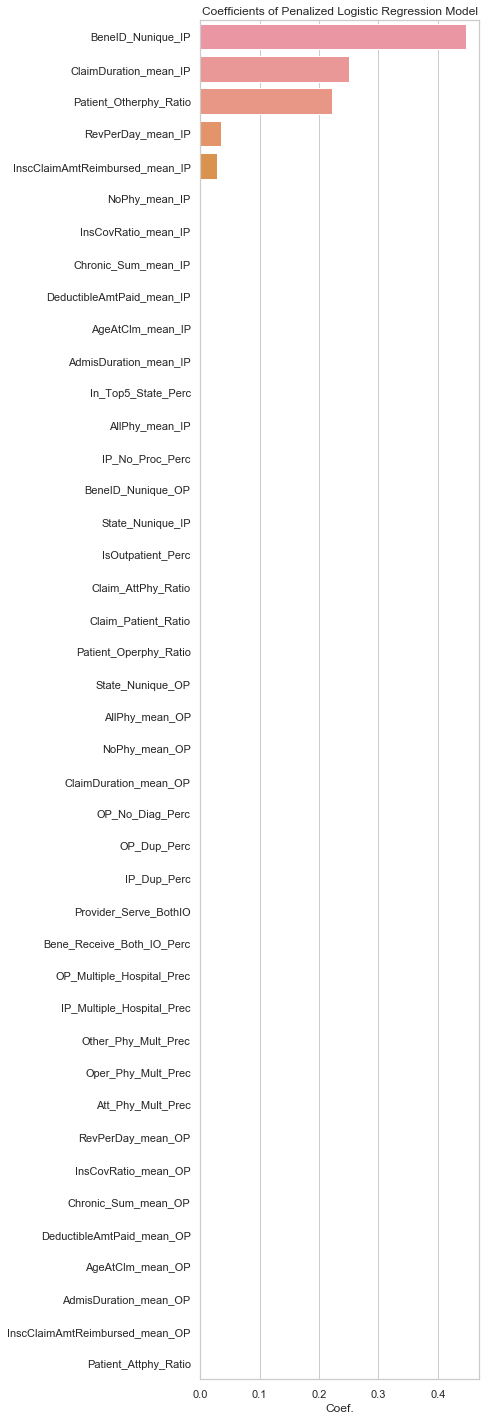

In [113]:
logistic_coef = pd.DataFrame(best_logistic.coef_.T, index = X.columns).rename(columns = {0:"Coef."})
logistic_coef = logistic_coef.reindex(logistic_coef["Coef."].abs().sort_values(ascending = False).index)
plt.figure(figsize = (5,25))
sns.barplot(data = logistic_coef.reset_index(), x = 'Coef.', y = 'index');
plt.title('Coefficients of Penalized Logistic Regression Model');
plt.ylabel('');

## Adjust feature selection by removing unimportant features 

In [14]:
# logistic_coef = logistic_coef.reset_index()
# notimportant = logistic_coef[logistic_coef['Coef.'].abs() == 0]['index'].tolist()
# print('Number of unimportant features distilled by lasso:', len(notimportant))

Number of unimportant features distilled by lasso: 66


In [15]:
# # Reset the dataset with selective columns
# X_train_reduced = X_train.iloc[:,~X_train.columns.isin(notimportant)]
# X_test_reduced = X_test.iloc[:,~X_test.columns.isin(notimportant)]

In [16]:
# print('Number of features after removing unimportant features:', X_train_reduced.shape[1])

Number of features after removing unimportant features: 20


## Random Forest

In [114]:
randomForest = RandomForestClassifier(random_state = 0, max_features = 'auto', class_weight = 'balanced_subsample')
grid_para_forest = {'n_estimators': [100,500,1000,2500,5000],
                    'max_depth': [15,20,30,40],
                    'min_samples_split': [2,4,8,12],
                    'min_samples_leaf' : [2,4,8,12]}

In [115]:
grid_search_forest = RandomizedSearchCV(randomForest,
                                        grid_para_forest,
                                        cv=skf, 
                                        n_jobs = 5, 
                                        verbose = 1,
                                        return_train_score = True,
                                        scoring = 'recall')
# Fit Random Forest 
para_search = grid_search_forest.fit(X_train, y_train)

# Save the best estimator
best_rf = para_search.best_estimator_
print('Best parameters:', para_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  2.0min finished


Best parameters: {'n_estimators': 1000, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_depth': 40}


In [116]:
eval_model('Random Forest', best_rf,X_train, X_test, y_train, y_test)

Random Forest score
------------------------------
Train: recall score: 0.95309
Test: recall score: 0.84158


In [117]:
confusion_matrix(y_train,best_rf.predict(X_train))

array([[3655,  268],
       [  19,  386]])

In [118]:
confusion_matrix(y_test,best_rf.predict(X_test))

array([[920,  61],
       [ 16,  85]])

In [147]:
grid_search_forest.cv_results_['mean_train_score']

array([1.        , 0.96234568, 0.95432099, 0.96234568, 0.9537037 ,
       0.99753086, 0.96234568, 1.        , 0.95493827, 0.9537037 ])

In [148]:
grid_search_forest.cv_results_['mean_test_score']

array([0.4962963 , 0.7382716 , 0.78765432, 0.73333333, 0.78765432,
       0.57530864, 0.7382716 , 0.4962963 , 0.79012346, 0.78765432])

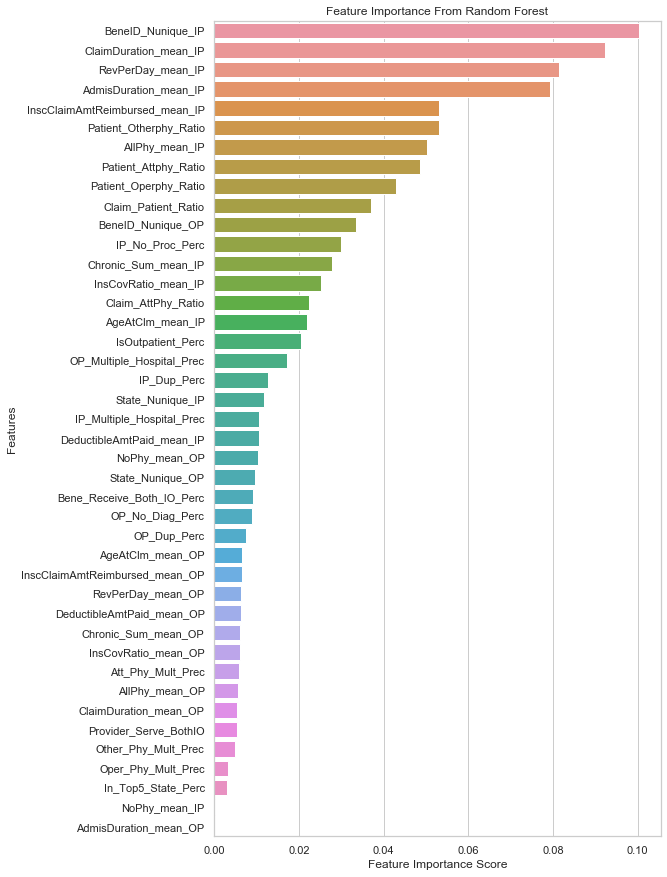

In [120]:
sorted_importance = sorted(zip(X_train.columns, best_rf.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (8,15))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance From Random Forest');
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');

In [23]:
# joblib.dump(best_rf,'best_rf1.pkl')

## Gradient Boosting

In [133]:
train = X_train.merge(y_train, on = 'Provider')
# Separate majority and minority classes
train_majority = train[train['PotentialFraud'] == 0]
train_minority = train[train['PotentialFraud'] == 1]
 
# Upsample minority class
train_minority_upsampled = resample(train_minority,
                                        replace = True,
                                        n_samples = train_majority.shape[0],
                                        random_state = 0)
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

# Separate input features (X) and target variable (y)
y_train_upsamp = train_upsampled['PotentialFraud']
X_train_upsamp = train_upsampled.drop('PotentialFraud', axis=1)

# Count of target variable after upsampling
Counter(y_train_upsamp)

Counter({0: 3923, 1: 3923})

In [122]:
gbm = GradientBoostingClassifier(random_state = 0, max_features = 'auto')
grid_para_gb = {'n_estimators': [100,500,1000,2500,5000,6000],
                'learning_rate':[0.01,0.05,0.08,0.1],
                'max_depth': [3,5,10,15,20],
                'min_samples_split': [2,4,6,8,10,12],
                'min_samples_leaf' : [2,4,6,8,10,12]}

In [134]:
grid_search_gb = RandomizedSearchCV(gbm, 
                                    grid_para_gb, 
                                    cv= skf, 
                                    n_jobs = 5, 
                                    verbose = 1,
                                    return_train_score = True,
                                    scoring = 'recall')
para_search = grid_search_gb.fit(X_train_upsamp, y_train_upsamp)
best_gb = para_search.best_estimator_
print('Best parameters:', para_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 21.4min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed: 29.6min finished


Best parameters: {'n_estimators': 6000, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_depth': 15, 'learning_rate': 0.01}


In [135]:
eval_model('Gradient Boosting', best_gb, X_train_upsamp, X_test, y_train_upsamp, y_test)

Gradient Boosting score
------------------------------
Train: recall score: 1.0
Test: recall score: 0.57426


In [136]:
confusion_matrix(y_train_upsamp,best_gb.predict(X_train_upsamp))

array([[3923,    0],
       [   0, 3923]])

In [137]:
confusion_matrix(y_test,best_gb.predict(X_test))

array([[967,  14],
       [ 43,  58]])

In [145]:
grid_search_gb.cv_results_['mean_train_score']

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97310764, 0.99490154, 1.        , 0.98266647])

In [146]:
grid_search_gb.cv_results_['mean_test_score']

array([1.        , 1.        , 1.        , 0.99897959, 0.99897959,
       1.        , 0.96609808, 0.99133628, 0.99897959, 0.97476537])

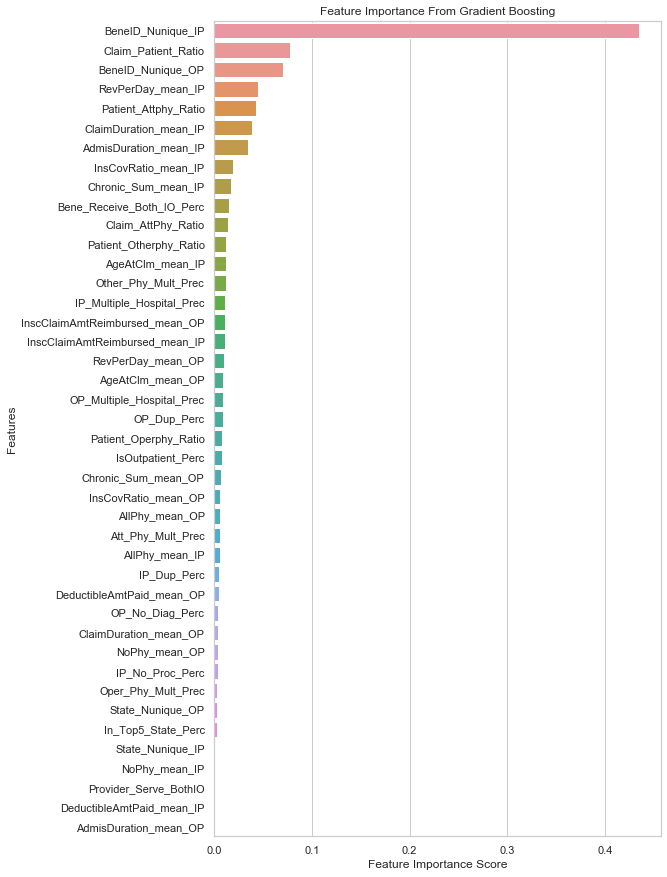

In [139]:
sorted_importance = sorted(zip(X_train.columns, best_gb.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (8,15))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance From Gradient Boosting');
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');

In [30]:
# joblib.dump(best_gb,'best_gb1.pkl')

## SVM

In [26]:
svm = SVC(random_state = 0, class_weight = 'balanced')
grid_para_svm = {'C':np.logspace(-3,2,100)}

In [27]:
grid_search_svm = RandomizedSearchCV(svm, 
                                    grid_para_svm, 
                                    cv= skf, 
                                    n_jobs = 5, 
                                    verbose = 1,
                                    return_train_score = True,
                                    scoring = 'recall')
para_search = grid_search_svm.fit(X_train, y_train)
best_svm = para_search.best_estimator_
print('Best parameters:', para_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   14.7s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   17.8s finished


Best parameters: {'C': 7.742636826811269}


In [28]:
eval_model('SVM', best_svm, X_train, X_test, y_train, y_test)

SVM score
------------------------------
Train: recall score: 0.90123
Test: recall score: 0.86139


In [29]:
confusion_matrix(y_train,best_svm.predict(X_train))

array([[3041,  882],
       [  40,  365]])

In [30]:
confusion_matrix(y_test,best_svm.predict(X_test))

array([[784, 197],
       [ 14,  87]])